In [2]:
using PyPlot

In [37]:
#size of the reservoir
global Nx=61;   #meshing
global Ny=61;

Lx=10000;   #inch
Ly=10000;

global z=50;  #reservoir depth

global dx=Lx/Nx;   #grid size
global dy=Ly/Ny;


global q_produce=1000;  #oil produce barrel per day 
global q_inject=-250;   #water injection 

C=0.001127;  #conversion coeff. convert the oil field unit into SI

0.001127

In [32]:
#Time step
global dt=1;   #time step. one day
global T=10;  #maximum time

#error
global err=1e-3   #error for residue in Newtonian method

0.001

In [5]:
#fliud and rock properties

#viscosity
muo=2;  #oil
muw=1;  #water

#porosity
global phistd=0.2;  #rock porosity

#compressibility
global cr =15e-6;   #1/psi
co=0;
cw=0;

#standard condition;
global pref=2500.0;   #initial pressure psi

# permeability
k = 100.0;          # unit md;

global To0=k/muo*C; #Conductance. pure oil S=0
global Tw0=k/muw*C; #Conductance. pure water S=1


0.1127

In [6]:
#porosity versus pressure
function phi(p)   
    global phistd
    global pref
    global cr
    phi=phistd*exp(cr*(p-pref));
    
    return phi;
end  

phi (generic function with 1 method)

In [7]:
#define variable 

pmat=fill(pref,Nx,Ny);
Smat=fill(0,Nx,Ny);

pmat_pre=fill(pref,Nx,Ny);
Smat_pre=fill(0.0,Nx,Ny);


kormat=fill(0.0,Nx,Ny);
kwrmat=fill(0.0,Nx,Ny);

kormatW=fill(0.0,Nx,Ny);
kwrmatW=fill(0.0,Nx,Ny);

#kormatE=fill(0.0,Nx,Ny);
#kwrmatE=fill(0.0,Nx,Ny);

kormatN=fill(0.0,Nx,Ny);
kwrmatN=fill(0.0,Nx,Ny);

#kormatS=fill(0.0,Nx,Ny);
#kwrmatS=fill(0.0,Nx,Ny);

#initialize kormat and kwrmat: average of the neighbours

kormat=(1-Smat).^2;
kwrmat=Smat.^2;

kormatW[:,2:end]=0.5* (kormat[:,1:end-1]+kormat[:,2:end]);
kwrmatW[:,2:end]=0.5* (kwrmat[:,1:end-1]+kwrmat[:,2:end]);

#kormatE[:,1:end-1]=kormatW[:,2:end];
#kwrmatE[:,1:end-1]=kwrmatW[:,2:end];

kormatN[2:end,:]=0.5* (kormat[1:end-1,:]+kormat[2:end,:]);
kwrmatN[2:end,:]=0.5* (kwrmat[1:end-1,:]+kwrmat[2:end,:]);

#kormatS[1:end-1,:]=kormatN[2:end,:];
#kwrmatS[1:end-1,:]=kwrmatN[2:end,:];


In [8]:
#Residue of Oil terms
function ComputeResOil(pmat,Smat,kormatW,kormatN,pmat_pre,Smat_pre)
    global To0;
    global Nx;
    global Ny;
    global q_produce;
    global z;


    ResOil=fill(0.0,Nx,Ny);
    #oil flow compute

    west_oil_flow_in=fill(0.0,Nx,Ny);
    east_oil_flow_in=fill(0.0,Nx,Ny);
    north_oil_flow_in=fill(0.0,Nx,Ny);
    south_oil_flow_in=fill(0.0,Nx,Ny);

    west_oil_flow_in[:,2:end]=To0*z*kormatW[:,2:end].*(pmat[:,1:end-1]-pmat[:,2:end]);
    east_oil_flow_in[:,1:end-1]= - west_oil_flow_in[:,2:end];
    
    north_oil_flow_in[2:end,:]=To0*z*kormatN[2:end,:].*(pmat[1:end-1,:]-pmat[2:end,:]);
    south_oil_flow_in[1:end-1,:]= -north_oil_flow_in[2:end,:];

    
    all_oil_flow_in=(west_oil_flow_in+east_oil_flow_in+north_oil_flow_in+south_oil_flow_in);

    ResOil=all_oil_flow_in-dx*dy*z/dt*  (phi(pmat).*(1-Smat)-phi(pmat_pre).*(1-Smat_pre));
    ResOil[div(Nx+1,2),div(Ny+1,2)]+=-q_produce;
    
    
    return ResOil;
end
    

ComputeResOil (generic function with 1 method)

In [9]:
#Residue of Water terms
function ComputeResWater(pmat,Smat,kwrmatW,kwrmatN,pmat_pre,Smat_pre)
    global Tw0;
    global Nx;
    global Ny;
    global q_inject;
    global z;
    
    ResWater=fill(0.0,Nx,Ny);
    
    west_water_flow_in=fill(0.0,Nx,Ny);
    east_water_flow_in=fill(0.0,Nx,Ny);
    north_water_flow_in=fill(0.0,Nx,Ny);
    south_water_flow_in=fill(0.0,Nx,Ny);   
    
    west_water_flow_in[:,2:end]=Tw0*z*kwrmatW[:,2:end].*(pmat[:,1:end-1]-pmat[:,2:end]);
    east_water_flow_in[:,1:end-1]= - west_water_flow_in[:,2:end];
    north_water_flow_in[2:end,:]=Tw0*z*kwrmatN[2:end,:].*(pmat[1:end-1,:]-pmat[2:end,:]);
    south_water_flow_in[1:end-1,:]= -north_water_flow_in[2:end,:];

    all_water_flow_in=(west_water_flow_in+east_water_flow_in+north_water_flow_in+south_water_flow_in);
    
    ResWater=all_water_flow_in-dx*dy*z/dt*(phi(pmat).*(Smat)-phi(pmat_pre).*(Smat_pre));
   
    ResWater[1,1]+= -q_inject;
    ResWater[1,Ny]+= -q_inject;
    ResWater[Nx,Ny]+= -q_inject;
    ResWater[Nx,1]+= -q_inject;
    
    return ResWater;
end


ComputeResWater (generic function with 1 method)

In [10]:
#Jacobian Construction
function ComputeJacobian(pmat,Smat,kormatW,kormatN,kwrmatW,kwrmatN)

    global Nx
    global Ny
    global dx
    global dy
    global z
    global dt
    global cr
    global To0
    global Tw0


#construct the Jacobian Submatrix
# A= self  B=west  C=east  F=north  G=south
# 11= Doil Dp  12 =Doil/DS  21= Dwater/Dp   22= Dwater/DS

    
    kormatE=fill(0.0,Nx,Ny);
    kwrmatE=fill(0.0,Nx,Ny);

    kormatS=fill(0.0,Nx,Ny);
    kwrmatS=fill(0.0,Nx,Ny);

    kormatE[:,1:end-1]=kormatW[:,2:end];
    kwrmatE[:,1:end-1]=kwrmatW[:,2:end];

    kormatS[1:end-1,:]=kormatN[2:end,:];
    kwrmatS[1:end-1,:]=kwrmatN[2:end,:];
    
    A11=fill(0.0,Nx,Ny);
    A12=fill(0.0,Nx,Ny);
    A21=fill(0.0,Nx,Ny);
    A22=fill(0.0,Nx,Ny);

#A11
    A11=-z*To0*(kormatW+kormatE+kormatN+kormatS)-dx*dy*z/dt*cr*(phi(pmat).*(1-Smat));

#A21
    A21=-z*Tw0*(kwrmatW+kwrmatE+kwrmatN+kwrmatS)-dx*dy*z/dt*cr*(phi(pmat).*(Smat));


#A12
    A12[1,1]=z*To0*(Smat[1,1]-1)*(pmat[2,1]+pmat[1,2]-2*pmat[1,1])+dx*dy*z/dt*phi(pmat[1,1]);
    A12[1,end]=z*To0*(Smat[1,end]-1)*(pmat[1,end-1]+pmat[2,end]-2*pmat[1,end])+dx*dy*z/dt*phi(pmat[1,end]);
    A12[end,1]=z*To0*(Smat[end,1]-1)*(pmat[end,2]+pmat[end-1,1]-2*pmat[end,1])+dx*dy*z/dt*phi(pmat[end,1]);
    A12[end,end]=z*To0*(Smat[end,end]-1)*(pmat[end-1,end]+pmat[end,end-1]-2*pmat[end,end])+dx*dy*z/dt*phi(pmat[end,end]);

    for i=2:Nx-1
        for j=2:Ny-1
            A12[i,j]= z*To0*(Smat[i,j]-1)*(pmat[i+1,j]+pmat[i-1,j]+pmat[i,j+1]+pmat[i,j-1]-4*pmat[i,j])+dx*dy*z/dt*phi(pmat[i,j])
        end
    end

    for j=2:Ny-1
        A12[1,j]=z*To0*(Smat[1,j]-1)*(pmat[2,j]+pmat[1,j+1]+pmat[1,j-1]-3*pmat[1,j])+dx*dy*z/dt*phi(pmat[1,j]);
        A12[Nx,j]=z*To0*(Smat[Nx,j]-1)*(pmat[Nx-1,j]+pmat[Nx,j+1]+pmat[Nx,j-1]-3*pmat[Nx,j])+dx*dy*z/dt*phi(pmat[1,j]);
    end

    for i=2:Nx-1
        A12[i,1]=z*To0*(Smat[i,1]-1)*(pmat[i,2]+pmat[i+1,1]+pmat[i-1,1]-3*pmat[i,1])+dx*dy*z/dt*phi(pmat[i,1]);
        A12[i,Ny]=z*To0*(Smat[i,Ny]-1)*(pmat[i,Ny-1]+pmat[i+1,Ny]+pmat[i-1,Ny]-3*pmat[i,Ny])+dx*dy*z/dt*phi(pmat[i,Ny]);
    end

#A22
    A22[1,1]=z*Tw0*Smat[1,1]*(pmat[2,1]+pmat[1,2]-2*pmat[1,1])-dx*dy*z/dt*phi(pmat[1,1]);
    A22[1,end]=z*Tw0*Smat[1,end]*(pmat[1,end-1]+pmat[2,end]-2*pmat[1,end])-dx*dy*z/dt*phi(pmat[1,end]);
    A22[end,1]=z*Tw0*Smat[end,1]*(pmat[end,2]+pmat[end-1,1]-2*pmat[end,1])-dx*dy*z/dt*phi(pmat[end,1]);
    A22[end,end]=z*Tw0*Smat[end,end]*(pmat[end-1,end]+pmat[end,end-1]-2*pmat[end,end])-dx*dy*z/dt*phi(pmat[end,end]);

    for i=2:Nx-1
        for j=2:Ny-1
            A22[i,j]= z*Tw0*(Smat[i,j])*(pmat[i+1,j]+pmat[i-1,j]+pmat[i,j+1]+pmat[i,j-1]-4*pmat[i,j])-dx*dy*z/dt*phi(pmat[i,j])
        end
    end

    for j=2:Ny-1
        A22[1,j]=z*Tw0*(Smat[1,j])*(pmat[2,j]+pmat[1,j+1]+pmat[1,j-1]-3*pmat[1,j])-dx*dy*z/dt*phi(pmat[1,j]);
        A22[Nx,j]=z*Tw0*(Smat[Nx,j])*(pmat[Nx-1,j]+pmat[Nx,j+1]+pmat[Nx,j-1]-3*pmat[Nx,j])-dx*dy*z/dt*phi(pmat[1,j]);
    end

    for i=2:Nx-1
        A22[i,1]=z*Tw0*(Smat[i,1])*(pmat[i,2]+pmat[i+1,1]+pmat[i-1,1]-3*pmat[i,1])-dx*dy*z/dt*phi(pmat[i,1]);
        A22[i,Ny]=z*Tw0*(Smat[i,Ny])*(pmat[i,Ny-1]+pmat[i+1,Ny]+pmat[i-1,Ny]-3*pmat[i,Ny])-dx*dy*z/dt*phi(pmat[i,Ny]);
    end


#West

    B11=fill(0.0,Nx,Ny);
    B12=fill(0.0,Nx,Ny);
    B21=fill(0.0,Nx,Ny);
    B22=fill(0.0,Nx,Ny);

    for i=1:Nx
        for j=2:Ny
            B11[i,j]=z*To0*kormatW[i,j];
            B12[i,j]=z*To0*(Smat[i,j-1]-1)*(pmat[i,j-1]-pmat[i,j]);
        end
    end

    for i=1:Nx
        for j=2:Ny
            B21[i,j]=z*Tw0*kwrmatW[i,j];
            B22[i,j]=z*Tw0*Smat[i,j-1]*(pmat[i,j-1]-pmat[i,j]);
        end
    end


#East

    C11=fill(0.0,Nx,Ny);
    C12=fill(0.0,Nx,Ny);
    C21=fill(0.0,Nx,Ny);
    C22=fill(0.0,Nx,Ny);

    for i=1:Nx
        for j=1:Ny-1
            C11[i,j]=z*To0*kormatE[i,j];
            C12[i,j]=z*To0*(Smat[i,j+1]-1)*(pmat[i,j+1]-pmat[i,j]);
        end
    end

    for i=1:Nx
        for j=1:Ny-1
            C21[i,j]=z*Tw0*kwrmatE[i,j];
            C22[i,j]=z*Tw0*Smat[i,j+1]*(pmat[i,j+1]-pmat[i,j]);
        end
    end

#North
    F11=fill(0.0,Nx,Ny);
    F12=fill(0.0,Nx,Ny);
    F21=fill(0.0,Nx,Ny);
    F22=fill(0.0,Nx,Ny);

    for i=2:Nx
        for j=1:Ny
            F11[i,j]=z*To0*kormatN[i,j];
            F12[i,j]=z*To0*(Smat[i-1,j]-1)*(pmat[i-1,j]-pmat[i,j]);
        end
    end

    for i=2:Nx
        for j=1:Ny
            F21[i,j]=z*Tw0*kwrmatN[i,j];
            F22[i,j]=z*Tw0*Smat[i-1,j]*(pmat[i-1,j]-pmat[i,j]);
        end
    end
   
    
    
#South

    G11=fill(0.0,Nx,Ny);
    G12=fill(0.0,Nx,Ny);
    G21=fill(0.0,Nx,Ny);
    G22=fill(0.0,Nx,Ny);

    for i=1:Nx-1
        for j=1:Ny
            G11[i,j]=z*To0*kormatS[i,j];
            G12[i,j]=z*To0*(Smat[i+1,j]-1)*(pmat[i+1,j]-pmat[i,j]);
        end
    end

    for i=1:Nx-1
        for j=1:Ny
            G21[i,j]=z*Tw0*kwrmatS[i,j];
            G22[i,j]=z*Tw0*Smat[i+1,j]*(pmat[i+1,j]-pmat[i,j]);
        end
    end

    

#Jacobian. Put all the derivatives into the right position
    J=spzeros(2*Nx*Ny,2*Nx*Ny);

    for i= 1:Nx
        for j=1:Ny
            m=2*(Nx*(i-1)+j)-1;
        
            J[m,m]=A11[i,j];
            J[m+1,m]=A21[i,j];
            J[m,m+1]=A12[i,j];
            J[m+1,m+1]=A22[i,j];
        end
    end

    for i=1:Nx-1
        for j=1:Ny
            m=2*(Nx*(i-1)+j)-1;
        
            J[m,m+2*Nx]=G11[i,j];
            J[m+1,m+2*Nx]=G21[i,j];
            J[m,m+2*Nx+1]=G12[i,j];
            J[m+1,m+2*Nx+1]=G22[i,j];
        
            J[m,m+2]=C11[i,j];
            J[m+1,m+2]=C21[i,j];
            J[m,m+3]=C12[i,j];
            J[m+1,m+3]=C22[i,j];
        
        end
    end


    for i=2:Nx
        for j=1:Ny
            m=2*(Nx*(i-1)+j)-1;
    
            J[m,m-2*Nx]=F11[i,j];
            J[m+1,m-2*Nx]=F21[i,j];
            J[m,m-2*Nx+1]=F12[i,j];
            J[m+1,m-2*Nx+1]=F22[i,j];
            
            J[m,m-2]=B11[i,j];
            J[m+1,m-2]=B21[i,j];
            J[m,m-1]=B12[i,j];
            J[m+1,m-1]=B22[i,j];
        
        end
    end


    for j=2:Ny
        i=1;
            m=2*(Nx*(i-1)+j)-1;
            J[m,m-2]=B11[i,j];
            J[m+1,m-2]=B21[i,j];
            J[m,m-1]=B12[i,j];
            J[m+1,m-1]=B22[i,j];
        
    end

    for j=1:Ny-1
        i=Nx;
            m=2*(Nx*(i-1)+j)-1;
            J[m,m+2]=C11[i,j];
            J[m+1,m+2]=C21[i,j];
            J[m,m+3]=C12[i,j];
            J[m+1,m+3]=C22[i,j];
    end
  
    
        return J;
    end
    

ComputeJacobian (generic function with 1 method)

In [11]:
#compute a single time step with Newtonian method
function ComputePandS(pmat_pre,Smat_pre)
#pmat=fill(pref,Nx,Ny);
#Smat=fill(0,Nx,Ny);

#pmat_pre=fill(pref,Nx,Ny);
#Smat_pre=fill(0.0,Nx,Ny);
    global err;
    global Nx
    global Ny
    global dx
    global dy
    global z
    global dt
    global cr
    global To0
    global Tw0
    
    pmat=pmat_pre;
    Smat=Smat_pre;
    
kormat=fill(0.0,Nx,Ny);
kwrmat=fill(0.0,Nx,Ny);

kormatW=fill(0.0,Nx,Ny);
kwrmatW=fill(0.0,Nx,Ny);

kormatN=fill(0.0,Nx,Ny);
kwrmatN=fill(0.0,Nx,Ny);

#initialize kormat and kwrmat: average of the neighbours

kormat=(1-Smat).^2;
kwrmat=Smat.^2;

kormatW[:,2:end]=0.5* (kormat[:,1:end-1]+kormat[:,2:end]);
kwrmatW[:,2:end]=0.5* (kwrmat[:,1:end-1]+kwrmat[:,2:end]);

kormatN[2:end,:]=0.5* (kormat[1:end-1,:]+kormat[2:end,:]);
kwrmatN[2:end,:]=0.5* (kwrmat[1:end-1,:]+kwrmat[2:end,:]);


pmat_reshaped=reshape(pmat,Nx*Ny,1);
Smat_reshaped=reshape(Smat,Nx*Ny,1);

x=fill(0.0,2*Nx*Ny,1);
x[1:2:2*Nx*Ny]=pmat_reshaped;
x[2:2:2*Nx*Ny]=Smat_reshaped;

ResOil=ComputeResOil(pmat,Smat,kormatW,kormatN,pmat_pre,Smat_pre);
ResWater=ComputeResWater(pmat,Smat,kwrmatW,kwrmatN,pmat_pre,Smat_pre);
count=0;

while (maximum(abs(ResOil))>err)|(maximum(abs(ResWater))>err)
    
    J=ComputeJacobian(pmat,Smat,kormatW,kormatN,kwrmatW,kwrmatN);
    
    ResWater_reshaped=reshape(ResWater,Nx*Ny,1);
    ResOil_reshaped=reshape(ResOil,Nx*Ny,1);
    pmat_reshaped=reshape(pmat,Nx*Ny,1);
    Smat_reshaped=reshape(Smat,Nx*Ny,1);


    b=fill(0.0,2*Nx*Ny,1);
    b[1:2:2*Nx*Ny]=ResOil_reshaped;
    b[2:2:2*Nx*Ny]=ResWater_reshaped;
    
    deltax=-J\b
    
    x=x+deltax;
    
    pmat=reshape(x[1:2:end],Nx,Ny);
    Smat=reshape(x[2:2:end],Nx,Ny);

    kormat=(1-Smat).^2;
    kwrmat=Smat.^2;

    kormatW[:,2:end]=0.5* (kormat[:,1:end-1]+kormat[:,2:end]);
    kwrmatW[:,2:end]=0.5* (kwrmat[:,1:end-1]+kwrmat[:,2:end]);

    kormatN[2:end,:]=0.5* (kormat[1:end-1,:]+kormat[2:end,:]);
    kwrmatN[2:end,:]=0.5* (kwrmat[1:end-1,:]+kwrmat[2:end,:]);
    ResOil=ComputeResOil(pmat,Smat,kormatW,kormatN,pmat_pre,Smat_pre);
    ResWater=ComputeResWater(pmat,Smat,kwrmatW,kwrmatN,pmat_pre,Smat_pre);
    count+=1;
        
end

    
    return pmat,Smat
end
    


ComputePandS (generic function with 1 method)

In [43]:
pmatT=fill(pref,Nx,Ny,T+1);
SmatT=fill(pref,Nx,Ny,T+1);

pmat=fill(pref,Nx,Ny);
Smat=fill(0.0,Nx,Ny);

tic();
for t=2:1:T+1
    pmat_pre=pmat;
    Smat_pre=Smat;
    pmat,Smat =ComputePandS(pmat_pre,Smat_pre);

    pmatT[:,:,t]=pmat;
    SmatT[:,:,t]=Smat;
end
toc()

elapsed time: 6.798972064 seconds


6.798972064

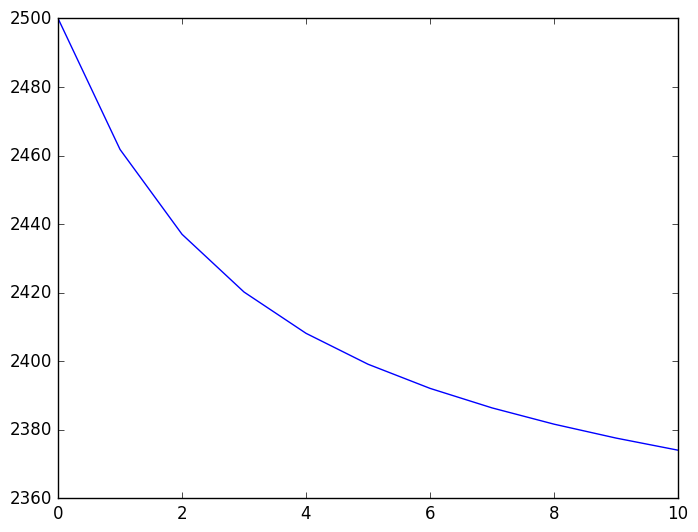

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3216cc610>

In [39]:
#pressure at the produce well versus time
plot(0:T,vec(pmatT[div(Nx+1,2),div(Ny+1,2),1:T+1]))

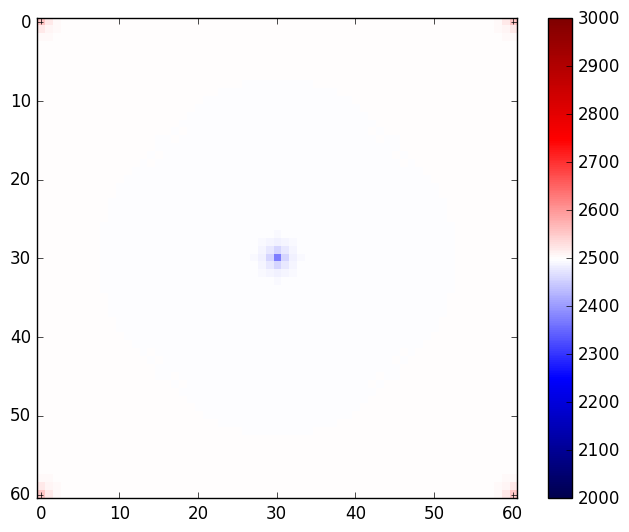

PyObject <matplotlib.colorbar.Colorbar object at 0x3202fce50>

In [40]:
#pressure distribution at T

imshow(pmatT[:,:,T+1], interpolation="nearest",vmax=pref + 500,vmin = pref - 500, ColorMap("seismic"))
colorbar()